# 1. Install Dependencies and Setup

In [5]:
!pip install tensorflow opencv-python matplotlib --user

In [14]:
!pip list

Package                      Version
---------------------------- --------
absl-py                      1.4.0
anyio                        3.7.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
async-lru                    2.0.2
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
cachetools                   5.3.1
certifi                      2023.5.7
cffi                         1.15.1
charset-normalizer           3.1.0
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
defusedxml                   0.7.1
executing                    1.2.0
fastjsonschema               2.17.1
flat

In [6]:
import tensorflow as tf
import os

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [24]:
!pip install matplotlib --user

In [47]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
from matplotlib import pyplot as plt

In [8]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 315 files belonging to 3 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

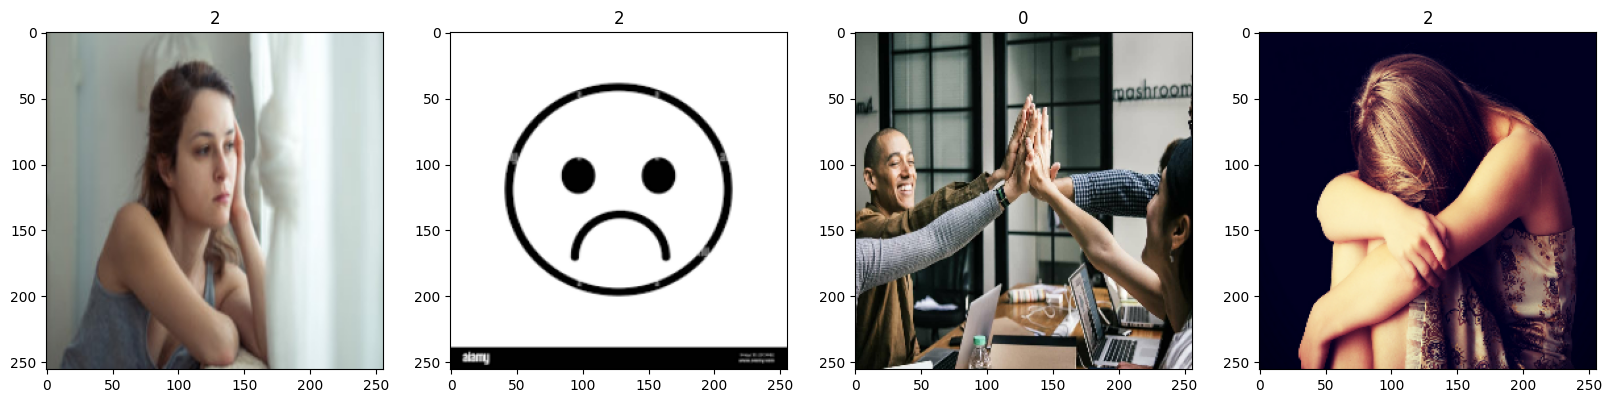

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [12]:
data = data.map(lambda x,y: (x/255, y))

In [13]:
data.as_numpy_iterator().next()

(array([[[[0.58431375, 0.5137255 , 0.35686275],
          [0.58465075, 0.5140625 , 0.35719976],
          [0.5861826 , 0.51559436, 0.35873163],
          ...,
          [0.7882353 , 0.77254903, 0.7607843 ],
          [0.7882353 , 0.77254903, 0.7607843 ],
          [0.7882353 , 0.77254903, 0.7607843 ]],
 
         [[0.58465075, 0.5140625 , 0.35719976],
          [0.5849588 , 0.51437056, 0.3575078 ],
          [0.586359  , 0.5157708 , 0.35890803],
          ...,
          [0.7865344 , 0.77084816, 0.75908345],
          [0.78627115, 0.7705849 , 0.7588202 ],
          [0.7862132 , 0.77052695, 0.75876224]],
 
         [[0.5861826 , 0.51559436, 0.35873163],
          [0.586359  , 0.5157708 , 0.35890803],
          [0.5871608 , 0.5165726 , 0.35970986],
          ...,
          [0.77880335, 0.7631171 , 0.75135237],
          [0.7773433 , 0.761657  , 0.7498923 ],
          [0.77702206, 0.7613358 , 0.7495711 ]],
 
         ...,
 
         [[0.0606924 , 0.0606924 , 0.05284926],
          [0.06102

# 5. Split Data

In [14]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [15]:
train_size

7

In [16]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [17]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [19]:
model = Sequential()

In [20]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [23]:
logdir='logs'

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 17s 2s/step - loss: 0.4848 - accuracy: 0.1116 - val_loss: 0.8973 - val_accuracy: 0.0312
Epoch 2/20
7/7 [==============================] - 12s 1s/step - loss: -0.1439 - accuracy: 0.0714 - val_loss: 0.2049 - val_accuracy: 0.3438
Epoch 3/20
7/7 [==============================] - 10s 1s/step - loss: -2.2690 - accuracy: 0.2545 - val_loss: -2.9777 - val_accuracy: 0.0312
Epoch 4/20
7/7 [==============================] - 10s 1s/step - loss: -3.4481 - accuracy: 0.1429 - val_loss: -12.1825 - val_accuracy: 0.3125
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: -11.3199 - accuracy: 0.1607 - val_loss: -5.5344 - val_accuracy: 0.1094
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: -35.9856 - accuracy: 0.2232 - val_loss: -82.8206 - val_accuracy: 0.0312
Epoch 7/20
7/7 [==============================] - 10s 1s/step - loss: -71.6883 - accuracy: 0.0848 - val_loss: -125.6085 - val_accuracy: 0.3906
Epoch 8/20
7/7 [

# 8. Plot Performance

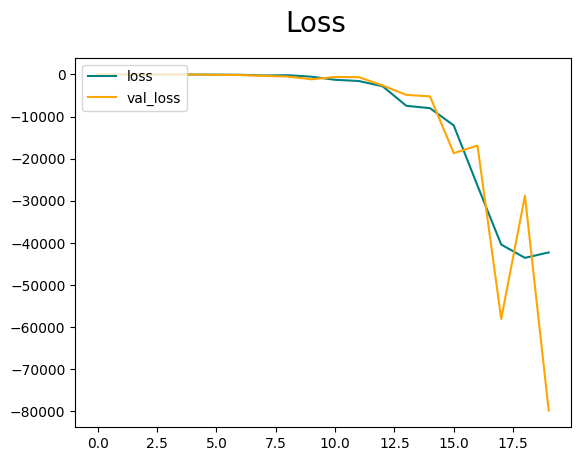

In [26]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

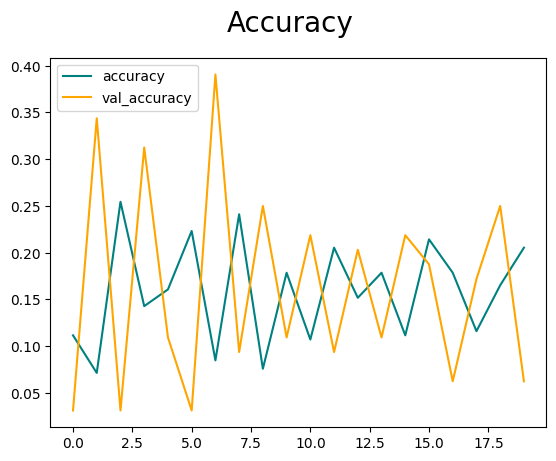

In [27]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [28]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [29]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [30]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 550ms/step


In [31]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.7692308, shape=(), dtype=float32) tf.Tensor(0.95238096, shape=(), dtype=float32) tf.Tensor(0.037037037, shape=(), dtype=float32)


# 10. Test

In [32]:
import cv2

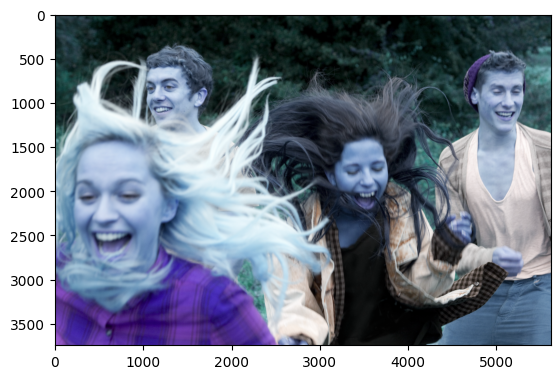

In [33]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

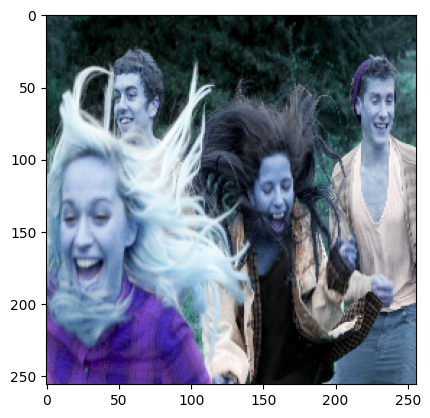

In [34]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [35]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 36ms/step


In [36]:
yhat

array([[1.]], dtype=float32)

In [37]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)